<a href="https://colab.research.google.com/github/keirkwame/axionEmu/blob/main/Open_access_version_of_4e5_Planck_2018_3x2pt_analysis_(ma%3D_29).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as sps
import getdist
from tqdm import trange
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')


using gpu:0 device 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install git+https://github.com/justinalsing/affine.git

In [2]:
import affine

In [3]:
from axionEmu.cosmopower.cosmopower_NN import cosmopower_NN

In [ ]:
from axionEmu.cosmopower.cosmopower_PCAplusNN import cosmopower_PCAplusNN

In [ ]:
##DM-like axions (m > 5.e-27 eV)

tt_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/content/drive/MyDrive/5e5_emulator_models/TT_cp_NN_5e5_DM_t2'
                               )

te_emu_model_ax = cosmopower_PCAplusNN(restore=True,
                                restore_filename='/content/drive/MyDrive/5e5_emulator_models/TE_cp_PCAplusNN_5e5_DM_t2'
                               )

ee_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/content/drive/MyDrive/5e5_emulator_models/EE_cp_NN_5e5_DM_t2'
                                )

In [ ]:
##DE-like axions (m < 5.e-27 eV)

tt_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/content/drive/MyDrive/5e5_emulator_models/TT_cp_NN_5e5_DE_t2'
                               )

te_emu_model_ax = cosmopower_PCAplusNN(restore=True,
                                restore_filename='/content/drive/MyDrive/5e5_emulator_models/TE_cp_PCAplusNN_5e5_DE_t2'
                               )

ee_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/content/drive/MyDrive/5e5_emulator_models/EE_cp_NN_5e5_DE_t2'
                                )

In [4]:
##Axion lensing model for ACT DR6
pp_emu_model_ax = cosmopower_NN(restore=True, restore_filename='/home/keir/Software/axionEmu/phi_NN_axion')


In [5]:
cosmo_params = dict()
cosmo_params['h'] = np.array([0.7])
cosmo_params['tau_reio'] = np.array([0.055])
cosmo_params['omega_b'] = np.array([0.0224])
cosmo_params['omega_cdm'] = np.array([0.12])
cosmo_params['n_s'] = np.array([0.96])
cosmo_params['omega_ax'] =np.array([0.001])
cosmo_params['log10ma'] = np.array([7],dtype='float64')
cosmo_params['ln10A_s'] = np.array([3.48])

In [6]:
len([list(cosmo_params.keys())])

1

In [7]:
b = pp_emu_model_ax.predictions_np(cosmo_params)

In [8]:
b[0].shape

(1499,)

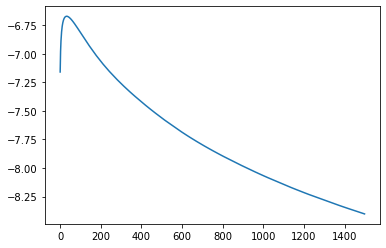

In [9]:
#Testing power spectrum prediction
plt.plot(b[0])

In [10]:
import act_dr6_lenslike as alike


In [11]:
##ACT DR6 likelihood
# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.019, 0.026, 'uniform'],
                         'omega_cdm':    [0.0003, 0.14, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.065, 0.015,   'gaussian'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          #'omega_ax': [1e-32, 0.01,  'uniform'],
                          #'yp':     [0.9, 1.1,  'uniform'],
                         }
fixed = {'log10ma': 7.0, 'omega_ax': 9.794086321726434e-10}

#Create prior arrays
prior_min = np.array([0.019, 0.0003, 0.55, 0.02, 0.86, 2.83])
prior_max = np.array([0.026, 0.14, 0.82, 0.12, 1.07, 3.4])

#Create Gaussian prior function
gaussian_obj = sps.norm(loc=0.065, scale=0.015)

#Load ACT DR6 data
variant = 'act_extended'
lens_only = True
like_corrections = False
trim_lmax = 1450
data_dict = alike.load_data(variant, lens_only=lens_only, like_corrections=like_corrections, trim_lmax=trim_lmax)

#@tf.function #Can't use graph mode until re-write likelihood in tf
def log_prob_ax(theta):
  """Posterior probability given ACT DR6 likelihood and emulated theory."""
  emulators=[pp_emu_model_ax,]
  ell=np.linspace(2,1500, 1499)

  emulator_pp = emulators[0]
  ell = ell.reshape(1, -1)

  #Create theta dictionary
  theta_dict = {key: theta[:, i].numpy() for i, key in enumerate(parameters_and_priors_ax.keys())}
  #yp = theta_dict['yp']
  #theta_dict.pop('yp', None)
  theta_all_dict = {**theta_dict, **fixed}
  for key in fixed.keys():
    theta_all_dict[key] = np.array([theta_all_dict[key],] * theta.shape[0])
  #print(theta_all_dict)

  #Get emulated theory vectors
  #d_ell_tt = emulator_tt.ten_to_predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2 #Check conversion!
  #print(d_ell_tt.shape, d_ell_tt)
  #d_ell_te = emulator_te.predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_te.shape, d_ell_te)
  #d_ell_ee = emulator_ee.ten_to_predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_ee.shape, d_ell_ee)
  c_ell_kk = emulator_pp.ten_to_predictions_np(theta_all_dict) * np.pi / 2.

  #Get likelihood
  #likelihood = np.array([like.loglike(d_ell_tt[i], d_ell_te[i], d_ell_ee[i], yp[i]**2.) for i in range(d_ell_tt.shape[0])])
  likelihood = np.ones(c_ell_kk.shape[0]) * -1.e+10
  for i in range(c_ell_kk.shape[0]):
    if np.sum(theta[i].numpy() > prior_max) + np.sum(theta[i].numpy() < prior_min):
      pass
    else:
      #print(ell[0].shape, c_ell_kk[i].shape)
      likelihood[i] = alike.generic_lnlike(data_dict, ell[0], c_ell_kk[i], ell[0], c_ell_kk[0], c_ell_kk[0], c_ell_kk[0], c_ell_kk[0], trim_lmax=trim_lmax) #like.loglike(d_ell_tt[i], d_ell_te[i], d_ell_ee[i], yp[i])

  #Apply any Gaussian prior
  #print(np.log(gaussian_obj.pdf(theta_all_dict['tau_reio'])))
  likelihood += np.log(gaussian_obj.pdf(theta_all_dict['tau_reio']))

  #print(likelihood)
  likelihood_tf = tf.convert_to_tensor(likelihood, np.float32)
  #print(likelihood_tf)

  return likelihood_tf

FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.1,  0.9658,  3.0753]).astype('float32'), (1, 6))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3]).astype('float32'), (1,6))


In [12]:
##Test ACT likelihood
theta_test = tf.convert_to_tensor(np.array([[0.02153, 0.1178, 0.679, 0.065, 1.008, 3.05], [0.021, 0.11, 0.71, 0.11, 0.91, 3.01], [0.0191, 0.11, 0.71, 0.11, 0.91, 3.01]]), np.float32)
print(theta_test)
likelihood_test = log_prob_ax(theta_test)
print('likelihood_test =', likelihood_test)


tf.Tensor(
[[0.02153 0.1178  0.679   0.065   1.008   3.05   ]
 [0.021   0.11    0.71    0.11    0.91    3.01   ]
 [0.0191  0.11    0.71    0.11    0.91    3.01   ]], shape=(3, 6), dtype=float32)
likelihood_test = tf.Tensor([-11.1558695 -33.1311    -30.318192 ], shape=(3,), dtype=float32)


In [ ]:
##m = 1e-25 axion
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_cdm':    [0.0003, 0.149, 'uniform'],
                         'h':            [0.64, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          'omega_ax': [1e-32, 0.09,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
fixed = {'log10ma': 7.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##m = 1e-25 axion
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.055,  0.9658,  3.0753,  0.05, 1.0080]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,  1E-2, 1E-4]).astype('float32'), (1,8))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##m = 1e-28 axion
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_lamda':    [0.16, 0.36, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
fixed = {'log10ma': 4.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##m = 1e-28 axion
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.3107,  0.673,  0.1,  0.9658,  3.0753,  0.005, 1.0080]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-3,     1E-2,   1E-3,   1E-3,    1E-3,  1E-3, 1E-4]).astype('float32'), (1,8))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##m = 1e-30 axion
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_lamda':    [0.16, 0.36, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
fixed = {'log10ma': 2.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##m = 1e-30 axion
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.3107,  0.673,  0.1,  0.9658,  3.0753,  0.005, 1.0080]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-3,     1E-2,   1E-3,   1E-3,    1E-3,  1E-3, 1E-4]).astype('float32'), (1,8))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##LCDM
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_cdm':    [0.0003, 0.149, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          #'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
fixed = {'log10ma': 2.0, 'omega_ax': 9.794086321726434e-10}
#fixed = {'log10ma': 2.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##LCDM
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.1,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,  1E-4]).astype('float32'), (1,7))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##All axion masses
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_lamda':    [0.16, 0.36, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          'log10ma': [3.999, 4.001, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
#fixed = {'log10ma': 4.0}
fixed={}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##All axion masses
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.3107,  0.673,  0.1,  0.9658,  3.0753, 4., 0.005, 1.0080]).astype('float32'), (1, 9))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-3,     1E-2,   1E-3,   1E-3,    1E-3, 1E-10,  1E-3, 1E-4]).astype('float32'), (1,9))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
@tf.function
def log_prob_ax(theta):
    return tf.squeeze(tf_planck_ax.posterior(theta), -1)

In [13]:
# number of parameters
n_params_ax = len(parameters_and_priors_ax)

# number of walkers (note you'll end up with a total of 2*n_walkers for this parallel variant of the affine sampler)
n_walkers = 50

# initialize walkers and current state
walkers1_ax = tf.random.normal([n_walkers, n_params_ax], FIDUCIAL, EPSILON)
walkers2_ax = tf.random.normal([n_walkers, n_params_ax], FIDUCIAL, EPSILON)
current_state_ax = [walkers1_ax, walkers2_ax]

In [ ]:
!pip install -U emcee

In [14]:
# number of MCMC steps to take (you'll end up with an MCMC chain with shape (n_steps, 2*n_walkers, n_parameters))
n_steps = 100

# run the sampler
with tf.device(device):
    chain_ax = affine.affine_sample(log_prob_ax, n_steps, current_state_ax, args=[])

100%|██████████| 99/99 [03:26<00:00,  2.08s/it]


In [15]:
burnin_steps = 20
samples_ax = chain_ax.numpy()[burnin_steps:,:,:].reshape((-1, n_params_ax))
#samples_2e4 = chain_2e4.numpy()[burnin_steps:,:,:].reshape((-1, n_params_ax))

In [16]:
samples_ax.shape

(8000, 6)

In [ ]:
np.linspace(100, 15500, 155)

In [ ]:
import emcee
auto = []
for i in np.linspace(100, 15500, 155):
  auto_time = np.mean(emcee.autocorr.integrated_time(chain_ax.numpy()[:int(i)], tol=0))
  auto.append(auto_time)

In [ ]:
import matplotlib.pyplot as plt
n = np.linspace(100, 15500, 155)
y = auto
plt.plot(n, n / 50.0, "--k")
plt.plot(n, y)
# plt.xlim(0, n.max())
# plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

In [ ]:
!pip install getdist

In [ ]:
##m = 1e-25 axion
import pickle
# f = open("/content/drive/MyDrive/2e5_emulator_models/test_2e5_0_likelihood_ax_7.pkl",'rb')
f = open("/content/drive/MyDrive/5e5_emulator_models/test_5e5_lamda_likelihood_ax_7.pkl",'rb')
samples_unflat2 = pickle.load(f)
samples_test2 = pickle.load(f)
diff2 = pickle.load(f)
# sampler1 = pickle.load(f)
f.close()

In [ ]:
##m = 1e-28 axion
import pickle
# f = open("/content/drive/MyDrive/2e5_emulator_models/test_2e5_0_likelihood_ax_7.pkl",'rb')
f = open("/content/drive/MyDrive/5e5_emulator_models/test_5e5_lamda_likelihood_ax_4.pkl",'rb')
samples_unflat2 = pickle.load(f)
samples_test2 = pickle.load(f)
diff2 = pickle.load(f)
# sampler1 = pickle.load(f)
f.close()

In [ ]:
##m = 1e-30 axion
import pickle
# f = open("/content/drive/MyDrive/2e5_emulator_models/test_2e5_0_likelihood_ax_7.pkl",'rb')
f = open("/content/drive/MyDrive/5e5_emulator_models/test_5e5_lamda_likelihood_ax_2.pkl",'rb')
samples_unflat2 = pickle.load(f)
samples_test2 = pickle.load(f)
diff2 = pickle.load(f)
# sampler1 = pickle.load(f)
f.close()

In [ ]:
samples_test = samples_unflat2[200:, :, :].reshape((-1, n_params_ax))

In [ ]:
samples_test.shape

In [ ]:
diff2

In [ ]:
#Testing samples from axionEmu
print(np.max(samples_ax[:10000, 0]))

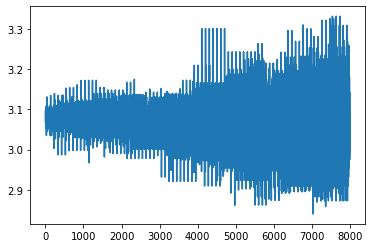

In [17]:
plt.plot(samples_ax[:, -1])

In [ ]:
##m = 1e-28 axion
# axionCAMB + EMCEE
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{lamda}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-28 axion
#g.triangle_plot([mcsamples, mcsamples_ax], filled=True, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-28)'])
g.triangle_plot([mcsamples], filled=True, legend_labels=['axionCAMB+EMCEE'])

In [ ]:
##m = 1e-28 axion
g.export('ma=1e-28_lamda.png')

In [ ]:
##m = 1e-28 axion
g.triangle_plot([mcsamples, mcsamples_ax], filled=False, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-28)'])

In [ ]:
##m = 1e-25 axion
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
# mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-25 axion
g.triangle_plot([mcsamples_ax], filled=True, legend_labels=['4e5 emulator+GPU sampler (ma=1e-25)'])

In [ ]:
##m = 1e-25 axion
# axionCAMB + EMCEE
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-25 axion
g.triangle_plot([mcsamples, mcsamples_ax], filled=False, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-25)'])

In [ ]:
##m = 1e-25 axion
g.export('new.png')

In [19]:
##LCDM
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",]
#r"log 10^{32} ma",
#r"\omega_{\mathrm{ax}}",
#r"A_{planck}"]
labels = names
# mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

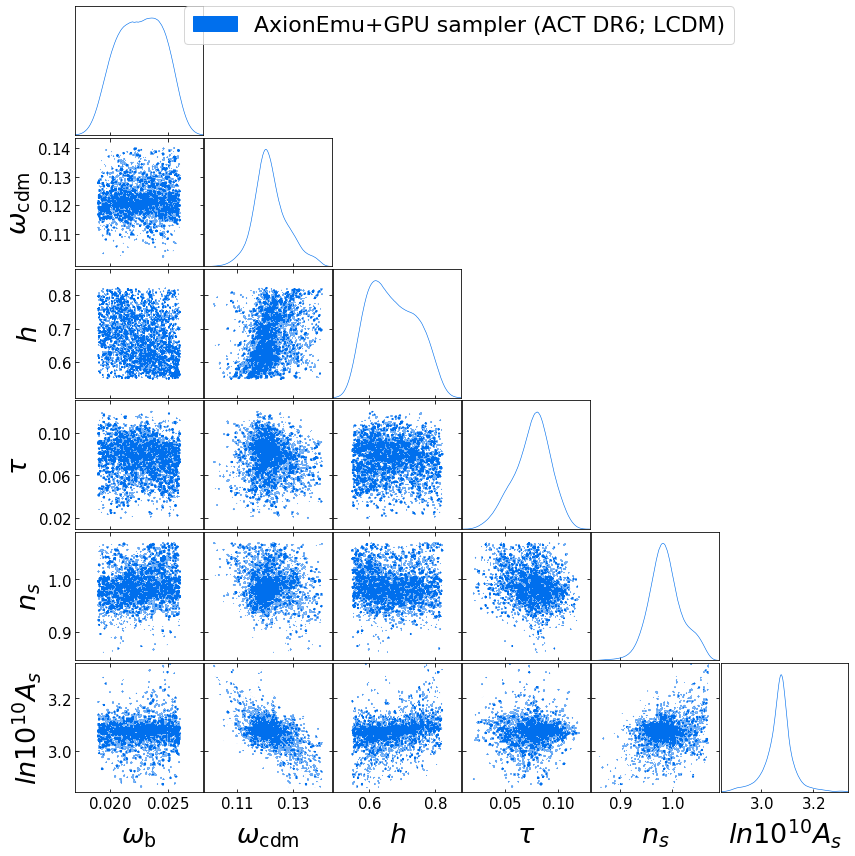

In [20]:
##LCDM
g.triangle_plot([mcsamples_ax], filled=True, legend_labels=['AxionEmu+GPU sampler (ACT DR6; LCDM)'])

In [ ]:
##All axion masses
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
# mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##All axion masses
g.triangle_plot([mcsamples_ax], filled=True, legend_labels=['4e5 emulator+GPU sampler (Vary axion mass)'])

In [ ]:
##m = 1e-30 axion
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{Lambda}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-30 axion
#g.triangle_plot([mcsamples, mcsamples_ax], filled=True, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-28)'])
g.triangle_plot([mcsamples], filled=True, legend_labels=['axionCAMB+EMCEE'])

In [ ]:
##m = 1e-30 axion
g.triangle_plot([mcsamples, mcsamples_ax], filled=False, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-30)'])